### 실험 노트

In [1]:
import os
import sys

sub_path = os.path.abspath(os.path.join('..'))
sys.path.append(sub_path)

In [2]:
import json
import pickle
import math
import numpy as np
import pandas as pd

from context import *
from ds.seq import *
from ds.leo_data import *
from ds.leo_multi_data import *
from ds.data_utils import *
from matplotlib import pyplot as plt

In [3]:
def set_gpu_memory_growth_mode(gpu_id=0):
    import tensorflow as tf
    try:
        gpus = tf.config.experimental.list_physical_devices('GPU')
        tf.config.experimental.set_memory_growth(gpus[gpu_id], True)
    except RuntimeError as e:
        print(e)
set_gpu_memory_growth_mode()        

In [4]:
np.set_printoptions(suppress=True)
np.set_printoptions(precision=3)

In [5]:
config = {
    'seed' : 1234,
    'shuffle' : False,
    'use_64bits': True,
    'use_calib_pick': True,
    'use_valid_only': False,
    'remove_blurry': False,
    
    'num_k_shots': 5,
    'num_valid_shot': 15,
    'batch_size' : 2,
    'num_epochs' : 20,
    'num_workers' : 8,
    'resource_path': '',
    'npy_root_path': '/home/elvin/host/mnt/ssd3/nps/',
    'landmark_root_path': '/home/elvin/host/mnt/ssd3/lms/legacy-lms/',
    'dmm_root_path': '/home/elvin/host/mnt/ssd3/lms/ms-3dmm-rev0',
}

ctx = Context.create(config)

In [6]:
summary, tr, val = load_split_and_summary(ctx.npy_root_path)
# pid_to_num_item = [(k,s['num_frames']) for k, s in summary.items()]
with open(os.path.join(ctx.npy_root_path, "cali-sample.json"), "r") as f:
    pid_to_calis = json.load(f)

In [7]:
def get_meta_and_frame(provider_id, item_id, as_meta=False):
    dp = dps[provider_id]
    try:
        meta, frame, face, lm = dp.item_by(item_id, as_meta)
    except Exception as e:
        return None, None, None, None
    return meta, frame, face, lm

In [8]:
def normalize_and_vis(m, frame=None, face=None, lm_2d=None, figsize=(9,9), show=False, only_primary=False):
    if m is None:
        return
    
    item_id = m['frame_id']
    frame_blur = clear_score(frame)
    
    norm_dist = 400
    norm_img_wh = (256, 128)
    norm_cam_mat = make_cam_mat(64*14, 64*14, norm_img_wh[0]/2, norm_img_wh[1]/2)
    norm_info = (norm_dist, norm_img_wh, norm_cam_mat)
    
    normalizer = normalize_niqab  # normalize
    nRs, nSs, nWs, Gots, nGots, eye_pos_both, t_xy, face_3d, R = normalizer(m, norm_info, landmark_2d=lm_2d)
    
    FR = m['rotate_mat']
    
    if frame is not None:
        if face.shape[:2] != (0,0):
            face_blur = clear_score(face)
        else:
            face_blur = -1

        le_pos, re_pos = eye_pos_both
        fx, fy, fz = m['head_pose'][3:]
        fx, fy, fz = round(fx), round(fy), round(fz)
        
        gaze_lt, gaze_rt = Gots
        ngaze_lt, ngaze_rt = nGots
        norm_le = cv2.warpPerspective(frame, nWs[0], norm_img_wh)
        norm_re = cv2.warpPerspective(frame, nWs[1], norm_img_wh)
        norm_le = to_gray_niqab(norm_le)
        
        norm_le, norm_re = DataProvider.get_both_eye_patch(norm_re)
        norm_le = to_gray_center(norm_le)
        norm_re = to_gray_center(norm_re)
        draw_both_eye(norm_le, norm_re, figsize=(6,6))
        
        facl = -le_pos[2] / gaze_lt[2]
        facr = -re_pos[2] / gaze_rt[2]
        
        p,y,r = to_yaw_pitch_roll(FR)
        y,p,r = round(y), round(p), round(r)
        is_prime = is_primary_pose(m)
        
        if show:
            print("blurry", frame_blur)
            print("R_xyz", y,p,r)
            print("eye_pos {} {}".format(le_pos, re_pos))
            print("gaze    {} {}".format(gaze_lt, gaze_rt))
            print("ngaze   {} {}".format(ngaze_lt, ngaze_rt))
            print("")
            print("target  {}".format(t_xy))
   
        fig = plt.figure(figsize=figsize)
        plt.imshow(frame)
        title = "[{}] {} Far: {}  EyZ: {} TB:{}  FB:{}  PP:{}  VAL: {}".format(
            item_id, t_xy, fz, round(le_pos[2]),
            frame_blur, face_blur, is_prime, 
            is_valid_item(m, True))
        
        plt.title(title)
        
        for i, lm in enumerate(lm_2d):
            #plt.plot(lm[0], lm[1], 'o')
            plt.text(lm[0], lm[1], str(i), color='red', fontsize=5)

In [9]:
def show_item(item, show_pc=None):
    stats = eval(item[0])
    n_stage = list(stats.keys())[0]

    stats = stats[n_stage]
    cnt   = int(stats['count'])
    mean  = stats['mean']
    std   = stats['std']
    pc_80 = stats['80%']
    pc_30 = stats['30%']
    
    if cnt < 900:
        return
    
    print("[{}]  m:{:.2f},   std:{:.2f}   30% {:.2f}   80% {:.2f}  #{}"
          .format(cnt, mean, std, pc_30, pc_80, n_stage))
    
    if show_pc is not None:
        pc_list = item[1][str(show_pc)]
        iids = [i[0] for i in pc_list]
        iids = sorted(iids)
        print(iids)
    return mean

def show(x):
    pid = list(x.keys())[0]
    items = x[pid]
    
    show_item(items[0])
    m = show_item(items[-1])
    return m

In [10]:
def make_p_list(n):
    return list(range(n*100, (n+1)*100, 10))

In [21]:
dps = [DataProvider(ctx, pid) for pid in ['02732']]

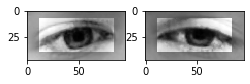

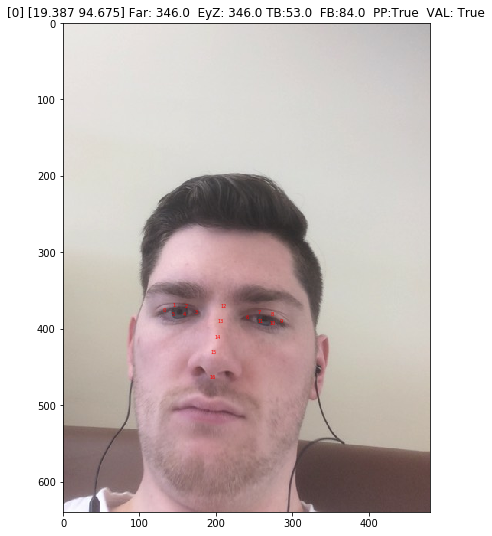

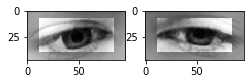

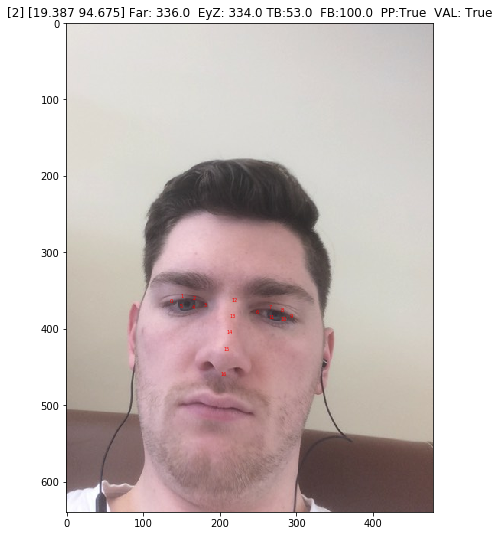

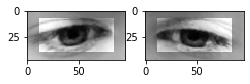

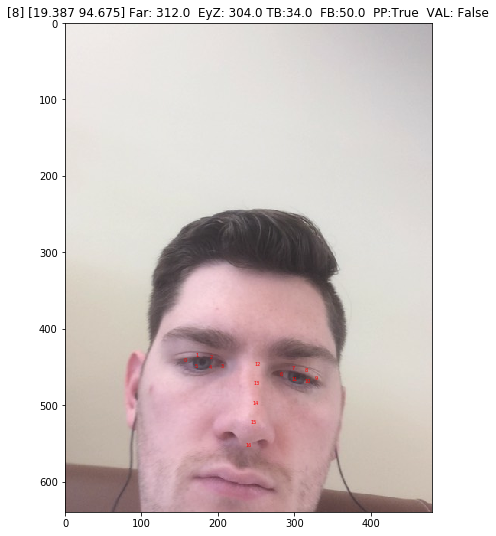

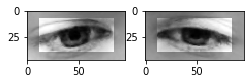

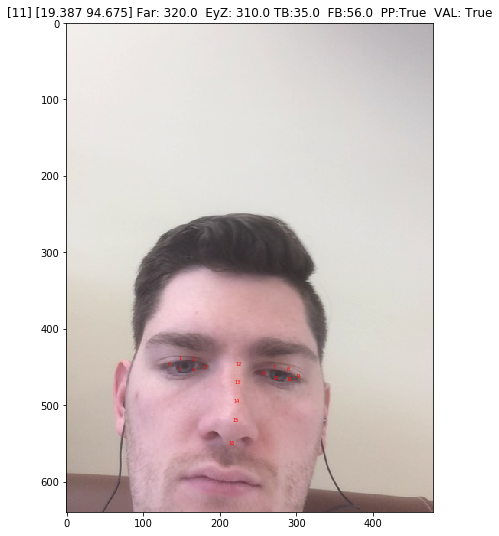

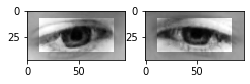

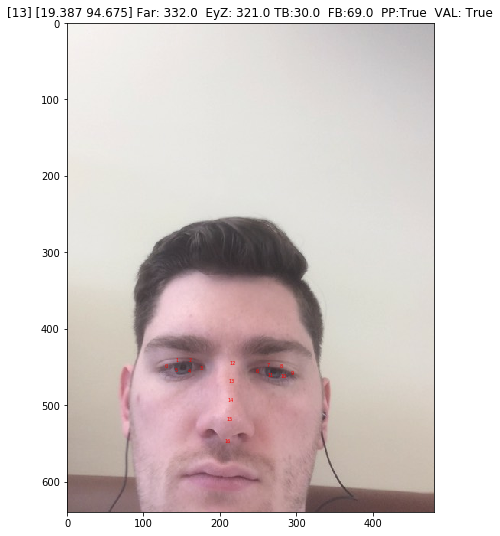

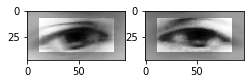

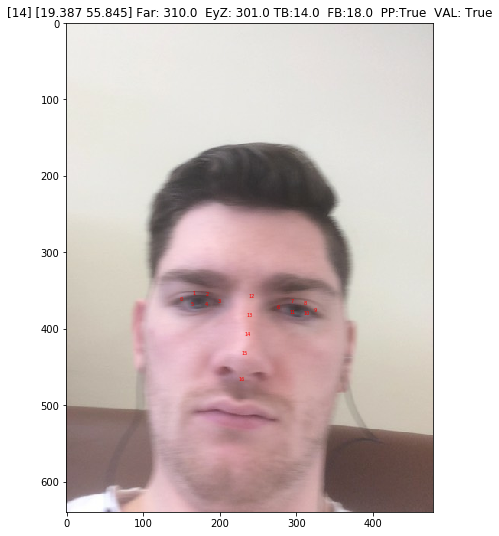

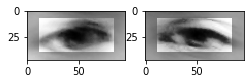

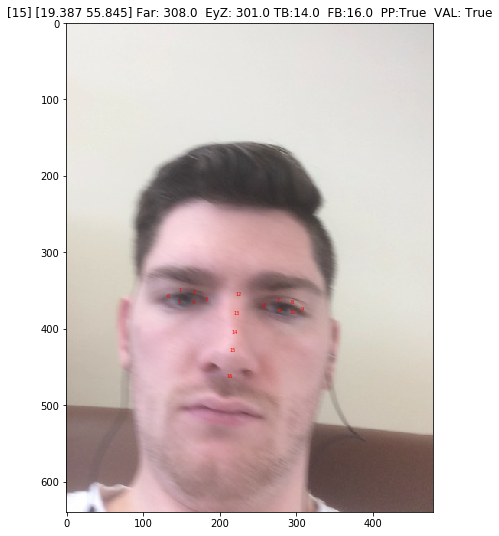

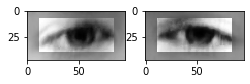

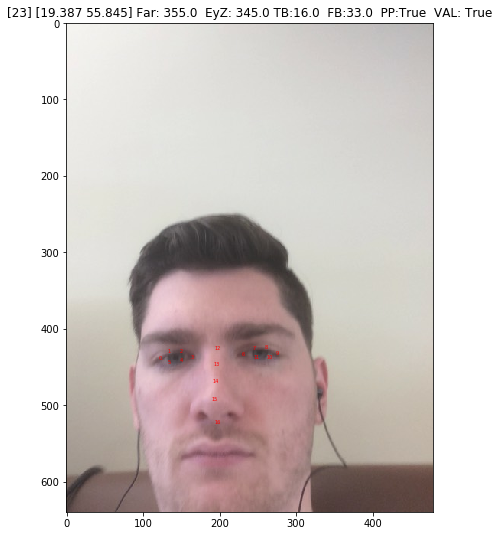

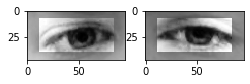

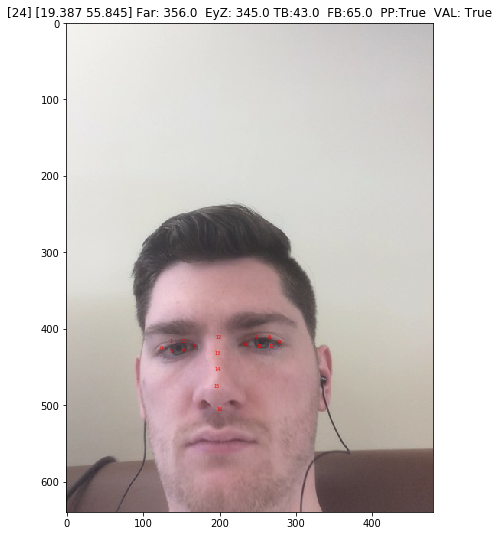

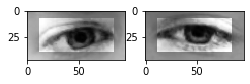

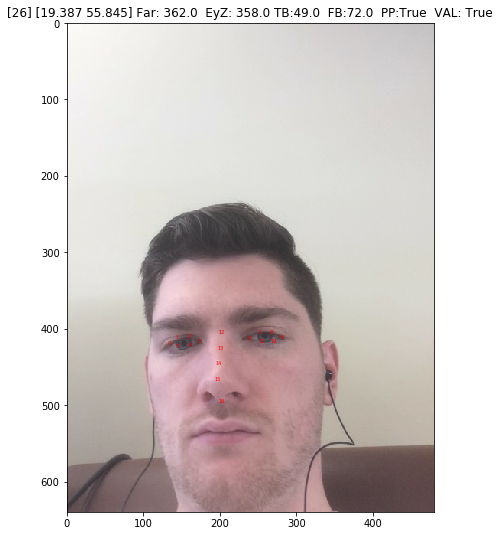

In [22]:
item_ids = [0, 2, 8, 11, 13, 14, 15, 23, 24, 26]
# item_ids = list(range(0, 10))
# item_ids = make_p_list(5)
for i in item_ids: # np.random.choice(item_ids, 5):
    m, frame, face, lm = get_meta_and_frame(0, i)
    normalize_and_vis(m, frame, face, lm_2d=lm)

# Report

In [13]:
from stats.report import *
from stats.profile_report import *

ModuleNotFoundError: No module named 'stats'

In [ ]:
target_pid = ['01738']
tr_pid = ['00239', '00247', '00376', '00623', '00835', '01231', '01327', '01456', '01731', '01734', '01738', '01760', '01762', '01763', '01773', '01802', '01816', '01818', '01849', '01860', '01862', '01866', '01882', '01907', '01924', '01926', '01933', '01965', '01979', '02023', '02024', '02058', '02064', '02077', '02085', '02086', '02092', '02105', '02112', '02136', '02152', '02159', '02319', '02347', '02367', '02373', '02420', '02421', '02465', '02518', '02522', '02575', '02576', '02581', '02585', '02732', '02954', '03214', '03231', '03263']
te_pid = ['00719', '01460', '01603', '01786', '01817', '01869', '01889', '01930', '01936', '01961', '01984', '02015', '02022', '02028', '02038', '02114', '02131', '02161', '02168', '02358', '02359', '02361', '02394', '02440', '02459', '02478', '02524', '02587', '02763', '03006']

In [ ]:
rs = grep_files(os.path.join(ctx.npy_root_path, "../report/"), "em-16-*")
# rs = [r for r in rs if r[-10:-5] in tr_pid]
rs = [r for r in rs if r[-10:-5] in target_pid]
Reports.summary(rs, 340)

<br>
<br>
<br>
<br>
<br>
<br>


# NEPTUNE TEST

In [ ]:
%env NEPTUNE_API_TOKEN='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiZGFkYTgwNjUtYWFiZS00MGUxLWI5YzctYjdjZjc2YzIwNDlkIn0='

In [ ]:
# import neptune as nai
# nai.init('vcchy/gaze')
# nai.create_experiment(name='LEO/ConfigTest', params=config)